# Lab 1

## Part 2: Neural Machine Translation in the wild
In the second part of the homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.
* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* or just fine-tunning BERT)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__
Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [0]:
! pip  install subword-nmt
! pip install nltk
! pip install torchtext==0.5.0
# ! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/Lab1_NLP/data.txt

# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

     |████████████████████████████████| 81kB 2.7MB/s 
     |████████████████████████████████| 1.0MB 8.1MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd ./'My Drive'
%cd Course_repos/ml_mipt_2019/homeworks_advanced/Lab1_NLP/LSTM_padded

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
/gdrive/My Drive
/gdrive/My Drive/Course_repos/ml_mipt_2019/homeworks_advanced/Lab1_NLP/LSTM_padded


# New Section

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time
import tqdm

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

from nltk.translate.bleu_score import corpus_bleu


In [0]:
SEED = 1984

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Main part

In [0]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [0]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            include_lengths = True,
            lower = True)

TRG = Field(tokenize="spacy",
            tokenizer_language="en",
            init_token = '<sos>', 
            eos_token = '<eos>',
            lower = True)

dataset = torchtext.data.TabularDataset(
    path='/gdrive/My Drive/Course_repos/ml_mipt_2019/homeworks_advanced/Lab1_NLP/data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [0]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

# New Section

In [0]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [0]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [0]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9188
Unique tokens in target (en) vocabulary: 6855


Here are tokens from original (RU) corpus:

In [0]:
SRC.vocab.itos[::1000]

['<unk>',
 'sea',
 'шеф',
 'качели',
 'школы',
 'франкфурт',
 'lago',
 'украшена',
 'евфразиева',
 'украшенных']

And from target (EN) corpus:

In [0]:
TRG.vocab.itos[::1000]

['<unk>', 'prague', 'texas', 'tuscany', 'heidelberg', 'quoc', 'korčula']

And here is example from train dataset:

In [0]:
print(vars(train_data.examples[9]))

{'trg': ['an', 'italian', 'breakfast', 'of', 'croissants', 'and', 'cappuccino', 'is', 'provided', 'daily', '.'], 'src': ['ежедневно', 'для', 'гостей', 'сервируют', 'итальянский', 'завтрак', 'с', 'круассанами', 'и', 'капучино', '.']}


Let's check the length distributions:

Length distribution in Train data


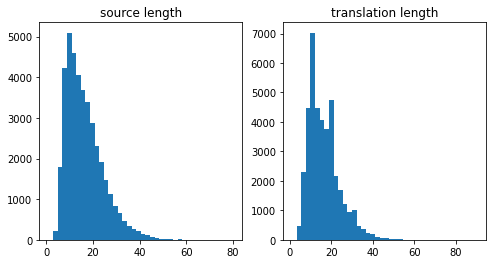

In [0]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=40);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=40);

Length distribution in Test data


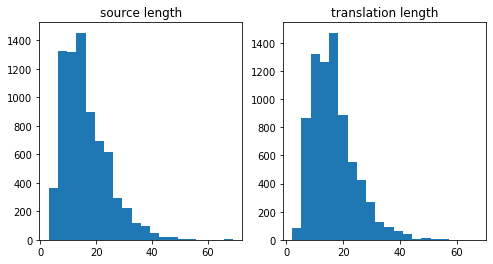

In [0]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Utils
Useful functions, specific for this approach

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
device

device(type='cuda')

In [0]:
def _len_sort_key(x):
    return len(x.src)

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None, scheduler=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()

        if scheduler:
          scheduler.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0)

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]


def get_text(x, TRG_vocab):
    tech_idx = [TRG_vocab[x] for x in ['<sos>', '<unk>', '<pad>']]
    eos_idx = TRG_vocab['<eos>']
    text = []
    for idx in x:
        if idx in tech_idx:
            continue
        elif idx == eos_idx:
            break
        else:
            text.append(TRG_vocab.itos[idx])

    if len(text) < 1:
        text = []
    return text
    
def generate_translation(src, src_len, trg, model, TRG_vocab):
    model.eval()

    output = model(src, src_len, trg, 0) #turn off teacher forcing
    output = output.argmax(dim=-1).cpu().numpy()

    original = [TRG_vocab.itos[x] for x in list(trg[:,0].cpu().numpy())]
    generated = [TRG_vocab.itos[x] for x in list(output[:, 0])]
    
    original = remove_tech_tokens(original)
    generated = remove_tech_tokens(generated)[1:]
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

### Attention, masked biLSTM, additive score, best result


This is the variant of seq2seq which makes use of `nn.utils.rnn.pack_padded_sequence`, and corrects model by applying mask with zeros corresponding positions of `<pad>` tokens in input. Our iterator now have to give us `src_len` as well, so we change pipeline a little bit.

In [0]:
import attention_padded_lstm as att_pad
Encoder = att_pad.Encoder
Attention = att_pad.Attention
Decoder = att_pad.Decoder
Seq2Seq = att_pad.Seq2Seq

In [0]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = _len_sort_key,
     device = device)

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ATTN_DIM = 64
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)

attn = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM)

dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device, SRC_PAD_IDX).to(device)

In [0]:
#%cd LSTM_padded
#model.load_state_dict(torch.load("attention_lstm_padded.pt"))
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9232, 256)
    (rnn): LSTM(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_W): Linear(in_features=1536, out_features=64, bias=True)
      (attn_v): Linear(in_features=64, out_features=1, bias=False)
    )
    (embedding): Embedding(6836, 256)
    (rnn): LSTM(1280, 512)
    (out): Linear(in_features=1792, out_features=6836, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [0]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,821,620 trainable parameters


In [0]:
optimizer = optim.Adam(model.parameters())

In [0]:
PAD_IDX = TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [0]:
train_history = []
valid_history = []

CLIP = 1
N_EPOCHS = 10

best_valid_loss = float('inf')

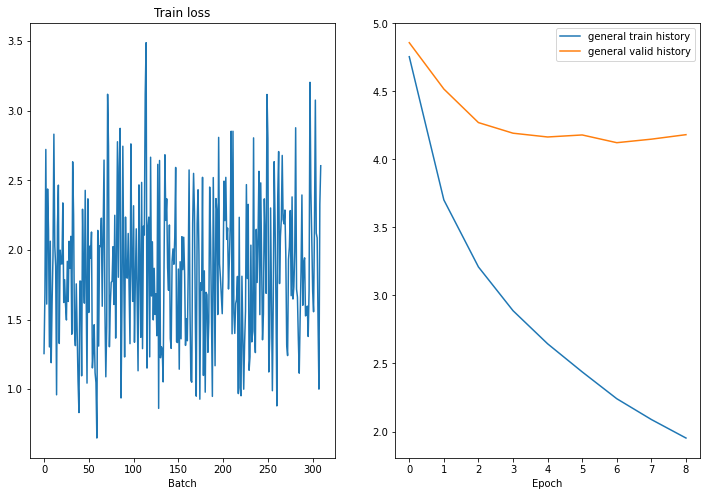

Epoch: 10 | Time: 1m 11s
	Train Loss: 1.841 | Train PPL:   6.301
	 Val. Loss: 4.160 |  Val. PPL:  64.097


In [0]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion,
                       CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attention_lstm_padded.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Again, let's take a look at our network quality__:

In [0]:
it = iter(test_iterator)

In [0]:
batch = next(it)

In [0]:
for idx in range(10):
    src = batch.src[0][:, idx:idx+1]
    src_len = batch.src[1][idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, src_len, trg, model, TRG.vocab)

Original: you will find a 24-hour front desk at the property .
Generated: you will find a 24-hour front desk at the property .

Original: this property also features free wifi .
Generated: free wifi access is available . . .

Original: there is a 24-hour front desk at the property .
Generated: you will find a 24-hour front desk at the property .

Original: hairdryers can be requested .
Generated: a hairdryer are available upon request . .

Original: you will find a 24-hour front desk at the property .
Generated: you will find a 24-hour front desk at the property .

Original: you will find a 24-hour front desk at the property .
Generated: there is a 24-hour front desk at the property . .

Original: guests enjoy free parking .
Generated: the property offers free parking . .

Original: free private parking is available .
Generated: free private parking is available on site .

Original: the property offers free parking .
Generated: the property offers free parking . .

Original: the proper

In [0]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src, src_len = batch.src
        trg = batch.trg

        output = model(src, src_len, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        output = output[1:, ...]
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:05, 11.00it/s]


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

27.246698344955966

As we can see, increase in performance is impressive. Train time increases too, but it is not that big - ???? in total.

### Linear schedule with warmup, dropout = 0.5


In [0]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9240, 256)
    (rnn): LSTM(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_W): Linear(in_features=1536, out_features=64, bias=True)
      (attn_v): Linear(in_features=64, out_features=1, bias=False)
    )
    (embedding): Embedding(6832, 256)
    (rnn): LSTM(1280, 512)
    (out): Linear(in_features=1792, out_features=6832, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [0]:
#!pip install transformers
from transformers.optimization import AdamW
optimizer = AdamW(model.parameters())

from transformers import get_linear_schedule_with_warmup

N_EPOCHS = 10

total_steps = len(train_iterator) * N_EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 100, 
                                            num_training_steps = total_steps)

In [0]:
PAD_IDX = TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [0]:
train_history = []
valid_history = []

CLIP = 1

best_valid_loss = float('inf')

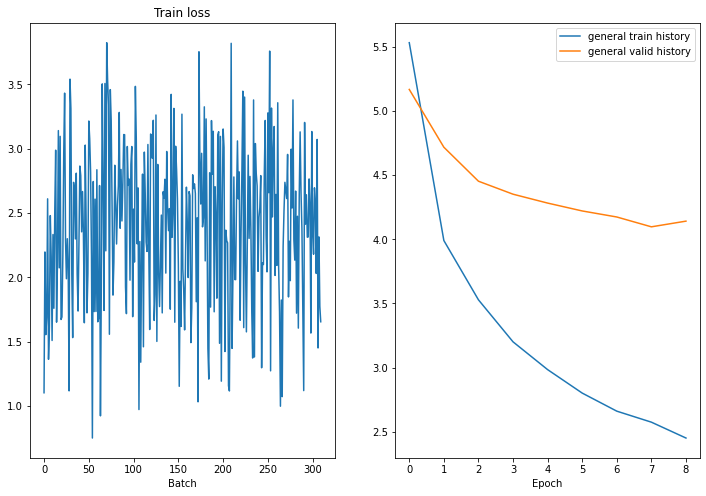

Epoch: 10 | Time: 1m 11s
	Train Loss: 2.394 | Train PPL:  10.953
	 Val. Loss: 4.132 |  Val. PPL:  62.274


In [0]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, 
                       CLIP, train_history, valid_history, scheduler)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'lstm_padded_1.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Again, let's take a look at our network quality__:

In [0]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src, src_len = batch.src
        trg = batch.trg

        output = model(src, src_len, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        output = output[1:, ...]
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:05, 11.28it/s]


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

21.826545206707628

As we can see, increase in performance is impressive. Train time increases too, but it is not that big - ???? in total.

### Hard cosine restarts, dropout = 0.3

In [0]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9240, 256)
    (rnn): LSTM(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_W): Linear(in_features=1536, out_features=64, bias=True)
      (attn_v): Linear(in_features=64, out_features=1, bias=False)
    )
    (embedding): Embedding(6832, 256)
    (rnn): LSTM(1280, 512)
    (out): Linear(in_features=1792, out_features=6832, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [0]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,815,472 trainable parameters


In [0]:
#!pip install transformers
from transformers.optimization import AdamW
optimizer = AdamW(model.parameters())

from transformers import get_cosine_with_hard_restarts_schedule_with_warmup

N_EPOCHS = 10

total_steps = len(train_iterator) * N_EPOCHS

scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 100, 
                                            num_training_steps = total_steps,
                                            num_cycles=3)

In [0]:
PAD_IDX = TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [0]:
train_history = []
valid_history = []

CLIP = 1

best_valid_loss = float('inf')

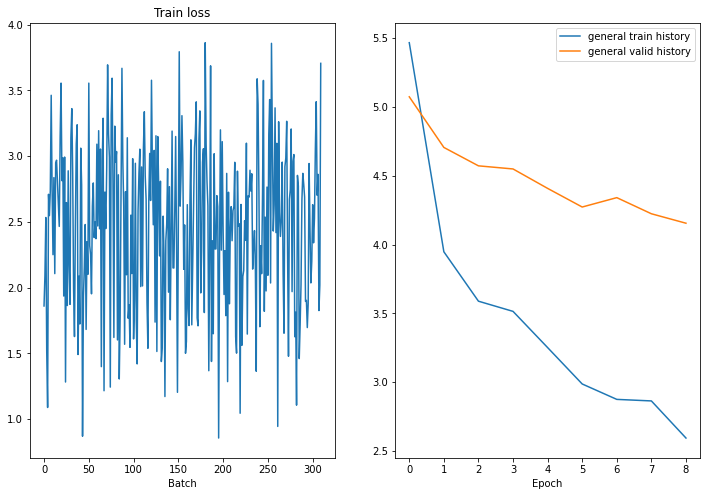

Epoch: 10 | Time: 1m 11s
	Train Loss: 2.453 | Train PPL:  11.623
	 Val. Loss: 4.137 |  Val. PPL:  62.601


In [0]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, 
                       CLIP, train_history, valid_history, scheduler)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attention_lstm_padded_2.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Again, let's take a look at our network quality__:

In [0]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src, src_len = batch.src
        trg = batch.trg

        output = model(src, src_len, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        output = output[1:, ...]
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

59it [00:05, 10.36it/s]


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

21.821900543430118

As we can see, increase in performance is impressive. Train time increases too, but it is not that big - ???? in total.